In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import requests
import statsmodels.tsa.stattools as ts
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from mlxtend.plotting import plot_linear_regression

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Create function to get asset values between a specific time period
def get_bitfinex_asset(asset, ts_ms_start, ts_ms_end):
    url = 'https://api.bitfinex.com/v2/candles/trade:1D:t' + asset + '/hist'
    params = { 'start': ts_ms_start, 'end': ts_ms_end, 'sort': 1}
    r = requests.get(url, params = params)
    data = r.json()
    return pd.DataFrame(data)[2]

In [ ]:
# Specify the time period to be focused
start_date = datetime(2018, 1, 1) #1514768400000 # 1 January 2018, 00:00:00
end_date = datetime(2018, 4, 30) #1527811199000  # 30 Apr 2018, 23:59:59
period = pd.date_range(start_date, end_date)
# Specify assets to be evaluated
assets = ['BTCUSD', 'ETHUSD', 'LTCUSD', 'XMRUSD', 'NEOUSD', 'XRPUSD', 'ZECUSD']

In [ ]:
crypto_prices = pd.DataFrame()

# Download the asset values from the bitfinex api and put them into dataframe
for a in assets:
    print('Downloading ' + a)
    crypto_prices[a] = get_bitfinex_asset(asset = a, ts_ms_start = start_date, ts_ms_end = end_date)

# Set index column as dates
crypto_prices['dates'] = pd.Series(period)
crypto_prices['dates']= pd.to_datetime(crypto_prices['dates'])
crypto_prices.set_index('dates', inplace=True, drop=True)
crypto_prices

,BTCUSD,ETHUSD,LTCUSD,XMRUSD,NEOUSD,XRPUSD,ZECUSD
dates,,,,,,,
2018-01-01,93.033000,11.197,3.14910,9.0275,31.150,0.32498,3591.300
2018-01-02,103.999000,11.750,2.99000,8.5982,25.890,0.34716,558.000
2018-01-03,118.229354,11.950,3.05000,8.2119,22.600,0.32800,1658.700
2018-01-04,134.700000,12.918,3.05000,8.1000,23.805,0.29717,1350.000
2018-01-05,132.899000,14.456,3.05000,7.7600,22.048,0.32158,943.100
...,...,...,...,...,...,...,...
2018-04-26,88.360000,12.136,2.64999,20.0000,74.995,0.21350,30.010
2018-04-27,90.240000,11.763,2.64000,19.5460,78.352,0.20996,27.112
2018-04-28,89.950000,11.471,2.55000,19.2360,88.820,0.19688,30.275


In [ ]:
# Normalize prices by first value
norm_prices = crypto_prices.divide(crypto_prices.iloc[0])

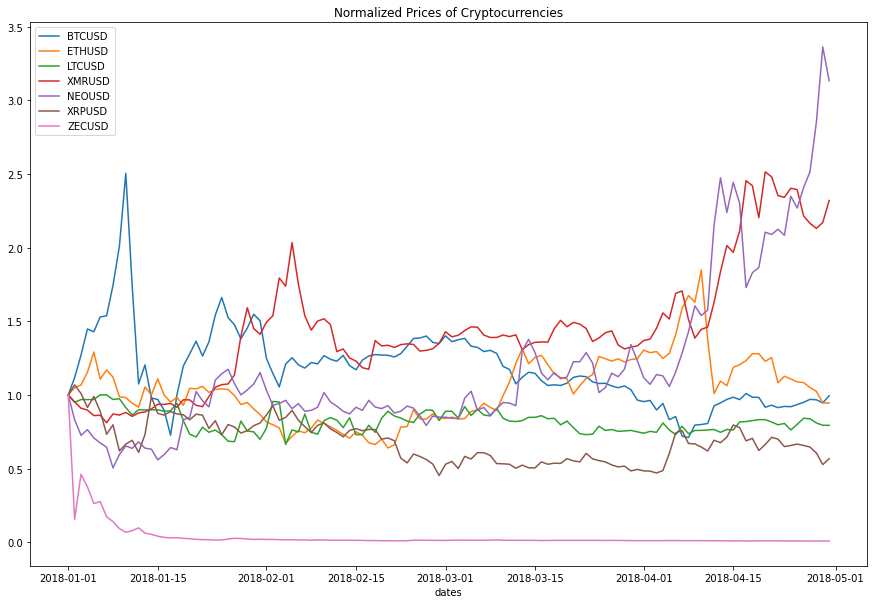

In [ ]:
# Plot all the assets with normalized prices
plt.figure(figsize = (15, 10))
plt.plot(norm_prices)
plt.xlabel('dates')
plt.title('Normalized Prices of Cryptocurrencies')
plt.legend(assets)
plt.show()

In [ ]:
# Find cointegrated pairs and also return cointegration matrix
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = ts.coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05: # if p-value is less than 0.05, then pairs are cointegrated
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs


[('BTCUSD', 'XMRUSD'), ('BTCUSD', 'NEOUSD'), ('XMRUSD', 'NEOUSD'), ('XRPUSD', 'ZECUSD')]


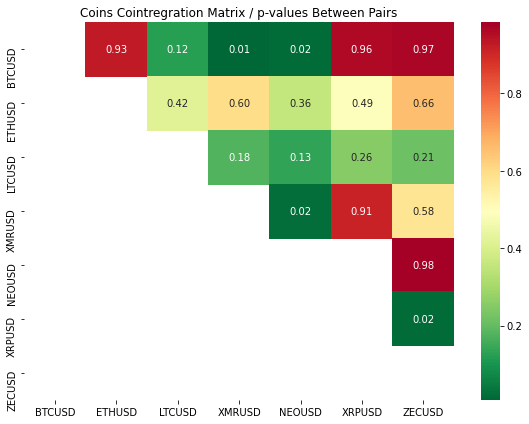

In [ ]:
# Calculate p-values of the pairs and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(crypto_prices)
print(pairs)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(pvalues, xticklabels = crypto_prices.columns,
                yticklabels = crypto_prices.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99)) # eliminate p-values greater than 0.99
ax.set_title('Coins Cointregration Matrix / p-values Between Pairs')
plt.tight_layout()


In [ ]:
# Select one of the cointegrated pairs 
coin1 = 'NEOUSD'
coin2 = 'XMRUSD'

P1 = crypto_prices[coin1] # prices of NEOUSD
P2 = crypto_prices[coin2] # prices of XMRUSD


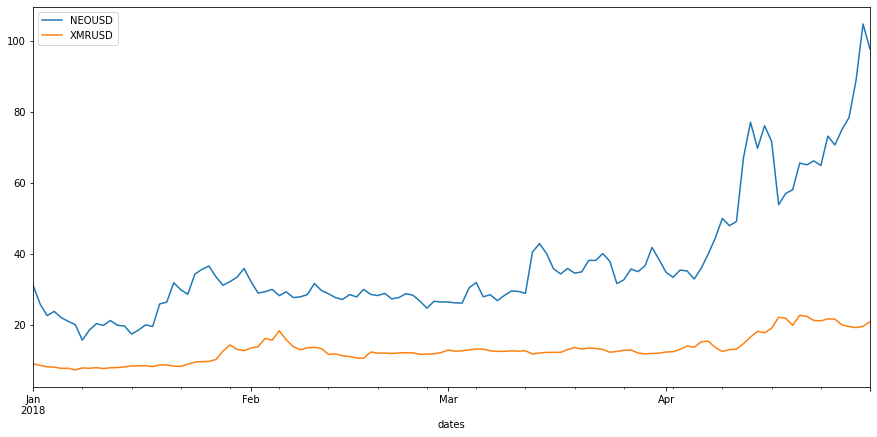

In [ ]:
# Plot pairs together
X = pd.Series((P1), name=coin1)
Y = pd.Series((P2), name=coin2)

pd.concat([X, Y], axis=1).plot(figsize=(15, 7))
plt.show()

In [ ]:
# Create train and test splits of crypto prices
train_data, test_data = train_test_split(crypto_prices, test_size=0.8, shuffle=False)

In [ ]:
# Fit train data on OLS regression model
ols_results = sm.OLS(train_data[coin2], train_data[coin1]).fit() # use OLS to get the coefficient for the linear combination between our pairs
print(ols_results.summary())


                                 OLS Regression Results                                
Dep. Variable:                 XMRUSD   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                              747.4
Date:                Sun, 30 May 2021   Prob (F-statistic):                    4.84e-19
Time:                        22:16:27   Log-Likelihood:                         -42.659
No. Observations:                  24   AIC:                                      87.32
Df Residuals:                      23   BIC:                                      88.50
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

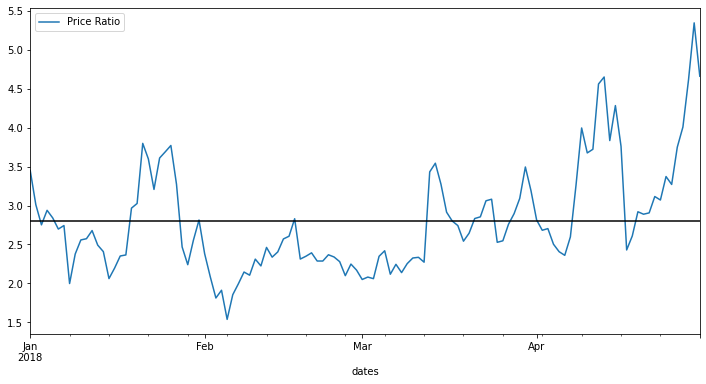

In [ ]:
# Calculate the price ratio between pairs
price_ratio = P1/P2
price_ratio.plot(figsize=(12,6))
plt.axhline(price_ratio.mean(), color='black')
plt.xlim('2018-01-01', '2018-04-30')
plt.legend(['Price Ratio']);


In [ ]:
# Calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)


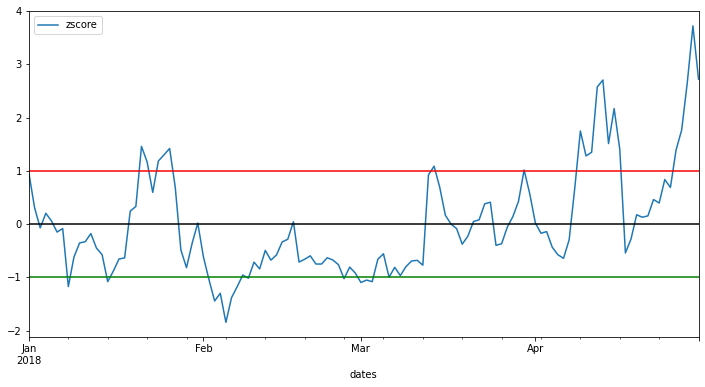

In [ ]:
# Plot zscore and its upper and lower bounds
zscore(price_ratio).plot(figsize=(12,6))
plt.axhline(zscore(price_ratio).mean(), color= 'black')
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2018-01-01', '2018-04-30')
plt.legend(['zscore']);
plt.show()

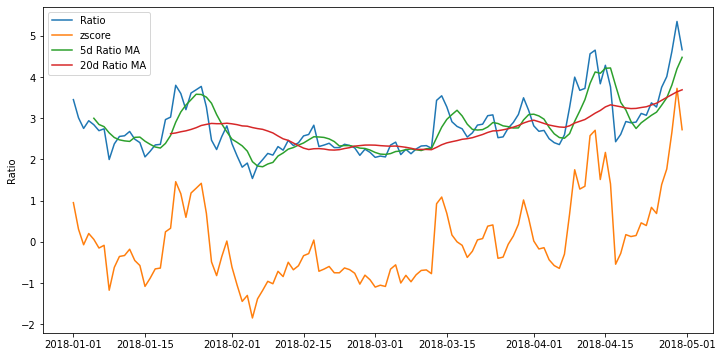

In [ ]:
# Try and observe different features on price and determine which is best at mimicking price ratio moves
ratios_mavg5 = price_ratio.rolling(window=5, center=False).mean() # 5 day moving average of price ratio
ratios_mavg20 = price_ratio.rolling(window=20, center=False).mean() # 20 day moving average of price ratio
zscore_all = zscore(price_ratio) # zscore 
plt.figure(figsize=(12, 6))
plt.plot(price_ratio.index, price_ratio.values) # plot train data
plt.plot(zscore_all.index, zscore_all.values) # plot zscore
plt.plot(ratios_mavg5.index, ratios_mavg5.values) # plot 5 day MA
plt.plot(ratios_mavg20.index, ratios_mavg20.values) # plot 20 day MA

plt.legend(['Ratio', 'zscore', '5d Ratio MA', '20d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

In [ ]:
# Find price ratios between test data of pairs
test_ratios = test_data[coin1] / test_data[coin2]

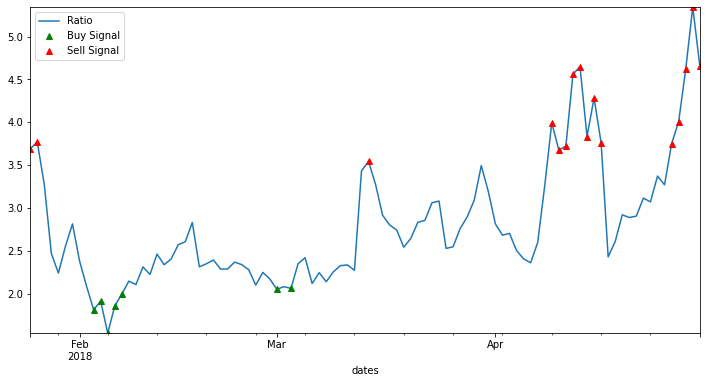

In [ ]:
# Since z score most accurately mimics the price ratio moves, we chose using it on our test data while sending signals  
plt.figure(figsize=(12,6))
test_ratios[0:].plot()
buy = test_ratios.copy()
sell = test_ratios.copy()
zscore_test = zscore(test_ratios) # find zscore on the test data
# Based on the zscores, send signals
buy[zscore_test > -1] = 0 # if zscore is greater than -1, do not send signal
sell[zscore_test < 1] = 0 # if zscore is less than 1, do not send signal
buy[0:].plot(color='g', linestyle='None', marker='^')
sell[0:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, price_ratio.min(), price_ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

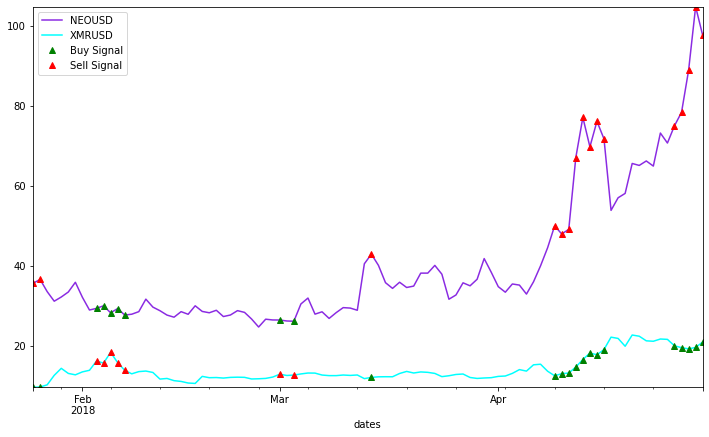

In [ ]:
plt.figure(figsize=(12,7))
P1 = test_data[coin1] # get test data for the first coin
P2 = test_data[coin2] # get test data for the second coin

P1[0:].plot(color='blueviolet')
P2[0:].plot(color='cyan')
buyR = 0*P1.copy()
sellR = 0*P1.copy()

# When you buy the ratio, you buy coin1 and sell coin2
buyR[buy!=0] = P1[buy!=0]
sellR[buy!=0] = P2[buy!=0]

# When you sell the ratio, you sell coin1 and buy coin2
buyR[sell!=0] = P2[sell!=0]
sellR[sell!=0] = P1[sell!=0]

buyR[0:].plot(color='g', linestyle='None', marker='^')
sellR[0:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(P1.min(), P2.min()), max(P1.max(), P2.max())))

plt.legend([coin1, coin2, 'Buy Signal', 'Sell Signal'])
plt.show()

In [ ]:
# Create signals df
signals = pd.DataFrame() 
signals[coin1] = P1 # test data for first coin
signals[coin2] = P2 # test data for second coin
signals['z'] = zscore_test
signals['z_upper_limit'] = np.mean(signals['z']) + np.std(signals['z']) 
signals['z_lower_limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [ ]:
# Assign signals for the coins
signals['signals1'] = np.select([signals['z'] > signals['z_upper_limit'], signals['z'] < signals['z_lower_limit']], [-1, 1])
signals['signals2'] = -signals['signals1']

In [ ]:
# Find portfolio positions (take the first order difference to obtain portfolio position in that asset)
signals['positions1'] = signals['signals1'].diff()
signals['positions2'] = signals['signals2'].diff()
signals

,NEOUSD,XMRUSD,z,z_upper_limit,z_lower_limit,signals1,signals2,positions1,positions2
dates,,,,,,,,,
2018-01-25,35.629,9.657,1.219691,1.0,-1.0,-1,1,NaN,NaN
2018-01-26,36.580,9.700,1.332219,1.0,-1.0,-1,1,0.0,0.0
2018-01-27,33.550,10.250,0.646240,1.0,-1.0,0,0,1.0,-1.0
2018-01-28,31.150,12.619,-0.462249,1.0,-1.0,0,0,0.0,0.0
2018-01-29,32.200,14.372,-0.776380,1.0,-1.0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2018-04-26,74.995,20.000,1.302761,1.0,-1.0,-1,1,-1.0,1.0
2018-04-27,78.352,19.546,1.659338,1.0,-1.0,-1,1,0.0,0.0
2018-04-28,88.820,19.236,2.497987,1.0,-1.0,-1,1,0.0,0.0


In [ ]:
# Assign initial capital as 100000 for each asset to calculate the actual pnl of the portfolio
initial_capital = 100000

# Shares to buy for each position 
positions1 = initial_capital // max(signals[coin1])
positions2 = initial_capital // max(signals[coin2])

In [ ]:
# Since there are two assets, we calculate each asset Pnl separately, and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio[coin1] = signals[coin1]
portfolio['holdings_'+coin1] = signals['positions1'].cumsum() * signals[coin1] * positions1
portfolio['cash_'+coin1] = initial_capital - (signals['positions1'] * signals[coin1] * positions1).cumsum()
portfolio['total_asset_'+coin1] = portfolio['holdings_'+coin1] + portfolio['cash_'+coin1]
portfolio['return_'+coin1] = portfolio['total_asset_'+coin1].pct_change()

In [ ]:
# Find pnl for the 2nd asset
portfolio[coin2] = signals[coin2]
portfolio['holdings_'+coin2] = signals['positions2'].cumsum() * signals[coin2] * positions2
portfolio['cash_'+coin2] = initial_capital - (signals['positions2'] * signals[coin2] * positions2).cumsum()
portfolio['total_asset_'+coin2] = portfolio['holdings_'+coin2] + portfolio['cash_'+coin2]
portfolio['return_'+coin2] = portfolio['total_asset_'+coin2].pct_change()

In [ ]:
# Find total pnl
portfolio['total asset'] = portfolio['total_asset_'+coin1] + portfolio['total_asset_'+coin2]
portfolio = portfolio.dropna()
portfolio

,NEOUSD,holdings_NEOUSD,cash_NEOUSD,total_asset_NEOUSD,return_NEOUSD,XMRUSD,holdings_XMRUSD,cash_XMRUSD,total_asset_XMRUSD,return_XMRUSD,total asset
dates,,,,,,,,,,,
2018-01-27,33.550,32006.700,67993.300,100000.000,0.000000,10.250,-45151.250,145151.25,100000.000,0.000000,200000.000
2018-01-28,31.150,29717.100,67993.300,97710.400,-0.022896,12.619,-55586.695,145151.25,89564.555,-0.104354,187274.955
2018-01-29,32.200,30718.800,67993.300,98712.100,0.010252,14.372,-63308.660,145151.25,81842.590,-0.086217,180554.690
2018-01-30,33.449,31910.346,67993.300,99903.646,0.012071,13.100,-57705.500,145151.25,87445.750,0.068463,187349.396
2018-01-31,35.877,34226.658,67993.300,102219.958,0.023185,12.749,-56159.345,145151.25,88991.905,0.017681,191211.863
...,...,...,...,...,...,...,...,...,...,...,...
2018-04-26,74.995,0.000,141013.414,141013.414,0.030085,20.000,0.000,114386.73,114386.730,0.066055,255400.144
2018-04-27,78.352,0.000,141013.414,141013.414,0.000000,19.546,0.000,114386.73,114386.730,0.000000,255400.144
2018-04-28,88.820,0.000,141013.414,141013.414,0.000000,19.236,0.000,114386.73,114386.730,0.000000,255400.144


In [ ]:
portfolio['z'] = signals['z']
portfolio['z_upper_limit'] = signals['z_upper_limit']
portfolio['z_lower_limit'] = signals['z_lower_limit']

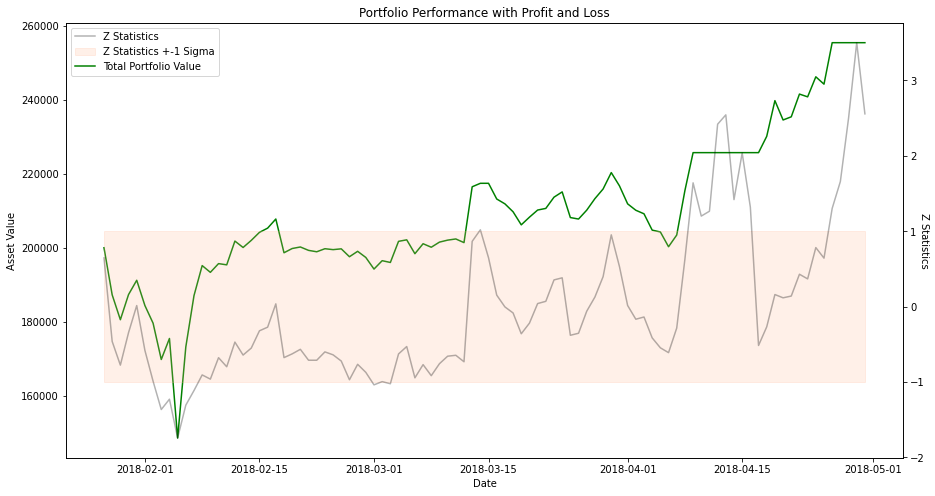

In [ ]:
# Plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
l1, = ax.plot(portfolio['total asset'], c='g') # plot total portfolio value
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3) # plot zscore of the test data
b = ax2.fill_between(portfolio.index,portfolio['z_upper_limit'], portfolio['z_lower_limit'], alpha=0.2, color='#ffb48f') # plot zscore upper and lower limits
ax.set_ylabel('Asset Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.set_xlabel('Date')
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics','Z Statistics +-1 Sigma','Total Portfolio Value'], loc='upper left');

In [ ]:
# Calculate total return for the number of days traded
initial_portfolio = portfolio['total asset'].iloc[0]
final_portfolio = portfolio['total asset'].iloc[-1]
days = (portfolio.index[-1] - portfolio.index[0]).days # find number of days traded
print('Number of days = ', days)
total_return = final_portfolio - portfolio['total asset'].iloc[0] # find total return at the end of trade
print('Total return of the portfolio = ', total_return)

# Calculate CAGR (compound annual growth rate)
YEAR_DAYS = 365
returns = (final_portfolio/initial_portfolio) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

# Calculate sharpe ratios
sharpe_ratio_BTC = portfolio['return_'+coin1].mean() / portfolio['return_'+coin1].std()
sharpe_ratio_ZEC = portfolio['return_'+coin2].mean() / portfolio['return_'+coin2].std()
annualized_sr_BTC = (YEAR_DAYS**0.5) * sharpe_ratio_BTC
annualized_sr_ZEC = (YEAR_DAYS**0.5) * sharpe_ratio_ZEC
print('Annualized sharpe ratio for NEOUSD: ', annualized_sr_BTC)
print('Annualized sharpe ratio for XMRUSD: ', annualized_sr_ZEC)

Number of days =  93
Total return of the portfolio =  55400.14400000003
CAGR = 161.079%
Annualized sharpe ratio for NEOUSD:  2.9993205624930668
Annualized sharpe ratio for XMRUSD:  1.0196488398864023


In [ ]:
# run linear regression
model_linreg = LinearRegression()
x_train = train_data[coin1].to_numpy().reshape(-1, 1)
y_train = train_data[coin2].to_numpy().reshape(-1, 1)
x_test = test_data[coin1].to_numpy().reshape(-1, 1)
y_test = test_data[coin2].to_numpy().reshape(-1, 1)

model_linreg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# make predictions
y_pred = model_linreg.predict(x_test)
print(y_pred)

[[ 9.13462045]
 [ 9.20030532]
 [ 8.99102547]
 [ 8.82525925]
 [ 8.89778197]
 [ 8.98404947]
 [ 9.15174963]
 [ 8.89260177]
 [ 8.67330688]
 [ 8.70162527]
 [ 8.74631308]
 [ 8.62482026]
 [ 8.69817181]
 [ 8.58627961]
 [ 8.60071509]
 [ 8.64485034]
 [ 8.86055364]
 [ 8.72331302]
 [ 8.66108162]
 [ 8.58565799]
 [ 8.54932756]
 [ 8.64485034]
 [ 8.59960998]
 [ 8.74603681]
 [ 8.64878729]
 [ 8.62558002]
 [ 8.66874831]
 [ 8.56030957]
 [ 8.5869703 ]
 [ 8.66232486]
 [ 8.63234881]
 [ 8.51790105]
 [ 8.37969346]
 [ 8.51465479]
 [ 8.50139349]
 [ 8.50063373]
 [ 8.48378083]
 [ 8.47963668]
 [ 8.7777396 ]
 [ 8.87961675]
 [ 8.60188926]
 [ 8.64236385]
 [ 8.52784702]
 [ 8.62758303]
 [ 8.71440309]
 [ 8.70666733]
 [ 8.66895551]
 [ 9.4715403 ]
 [ 9.63709931]
 [ 9.44377446]
 [ 9.14504991]
 [ 9.04669529]
 [ 9.15257846]
 [ 9.06189052]
 [ 9.0862029 ]
 [ 9.3099873 ]
 [ 9.31005637]
 [ 9.44336004]
 [ 9.2913386 ]
 [ 8.8595176 ]
 [ 8.93286915]
 [ 9.14256342]
 [ 9.09103775]
 [ 9.20424227]
 [ 9.56084685]
 [ 9.32601137]
 [ 9.07618

In [ ]:
df = pd.DataFrame(y_test, columns=['Actual'])
df['Predicted'] = y_pred
df.head()

,Actual,Predicted
0,9.657,9.134620
1,9.700,9.200305
2,10.250,8.991025
3,12.619,8.825259
4,14.372,8.897782


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 4.731574951470747
Mean Squared Error: 28.294542709138515
Root Mean Squared Error: 5.319261481553479


In [ ]:
y_pred2 = ols_results.predict(x_test)
print(y_pred2)

[12.30895866 12.63750618 11.59071439 10.76157238 11.12432201 11.55582133
 12.39463666 11.09841132 10.00152553 10.14317062 10.36669349  9.75900149
 10.12589683  9.56622597  9.63843042  9.85918948 10.93811053 10.25165004
  9.94037631  9.56311669  9.3813964   9.85918948  9.63290281 10.36531159
  9.87888161  9.76280173  9.97872412  9.43632706  9.56968073  9.94659487
  9.79665836  9.22420489  8.53290774  9.20796753  9.14163617  9.13783593
  9.05353983  9.03281128 10.523885   11.03346186  9.64430351  9.84675235
  9.27395341  9.77282052 10.20708365 10.16839036  9.97976055 13.9941898
 14.82229538 13.85530851 12.36112551 11.86916791 12.39878237 11.9451726
 12.06678009 13.18612181 13.18646729 13.85323566 13.09284333 10.93292839
 11.29982373 12.34868838 12.0909634  12.6571983  14.44089006 13.26627221
 12.0166861  11.53889301 12.24988229 12.1524581  11.37651937 12.43713019
 13.81903355 15.37712958 17.2699917  16.56556647 16.96286368 23.1610457
 26.62893217 24.09313951 26.29036585 24.77579977 18.60

In [ ]:
df = pd.DataFrame(y_test, columns=['Actual'])
df['Predicted'] = y_pred2
df.head()


,Actual,Predicted
0,9.657,12.308959
1,9.700,12.637506
2,10.250,11.590714
3,12.619,10.761572
4,14.372,11.124322


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred2))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))

Mean Absolute Error: 3.0054617273361117
Mean Squared Error: 16.732055289004
Root Mean Squared Error: 4.090483503084201
